# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
data.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


## Preparation

In [7]:
# convert datetime to Datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

In [8]:
# set datetime as the index for resample by hour
data.set_index('datetime', inplace=True)
hourly_data = data.resample('H').sum()

In [9]:
# check for missing timestamps after resampling
hourly_data['num_orders'].fillna(0, inplace=True)

In [10]:
# display rows to confirm changes
display(hourly_data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
# summary stats
display(hourly_data['num_orders'].describe())

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

## Analysis

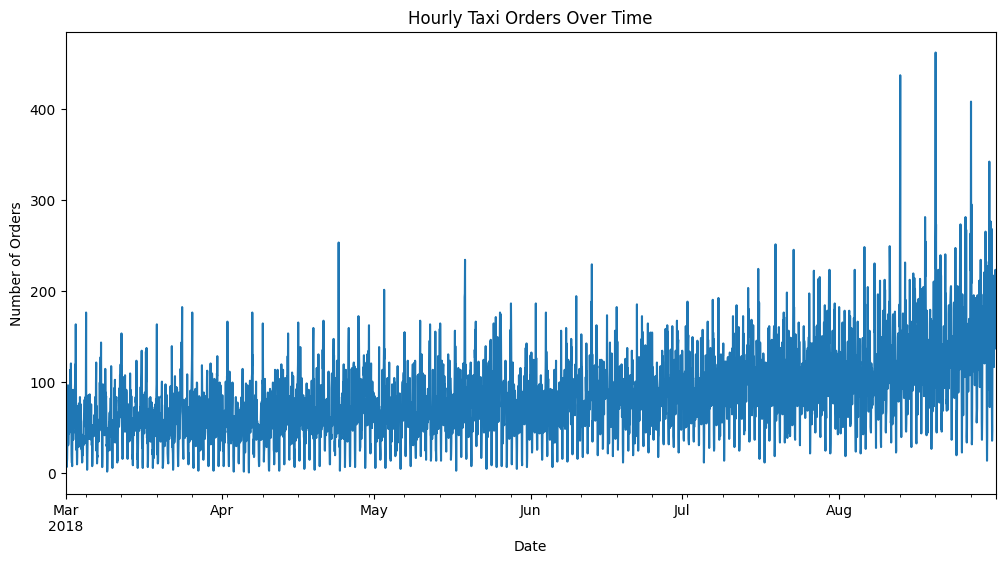

In [12]:
# visualize overall trends
hourly_data['num_orders'].plot(figsize=(12, 6), title="Hourly Taxi Orders Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

Over time, you see that more taxi's are ordered towards the end of the year more than the middle of the year. There are some spikes in the summer months. 

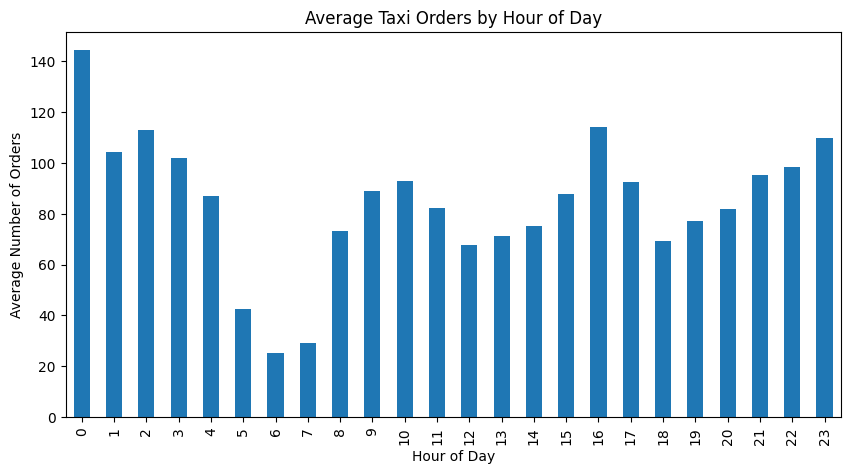

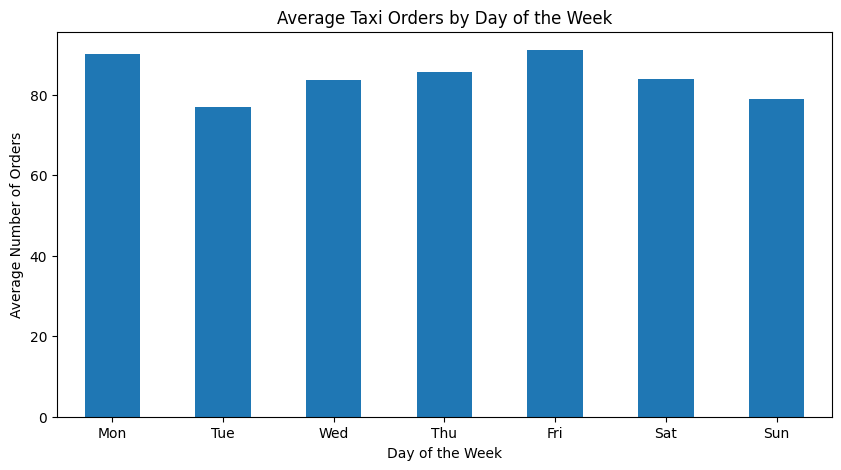

In [13]:
# average orders by hour of day
hourly_data['hour'] = hourly_data.index.hour
avg_orders_by_hour = hourly_data.groupby('hour')['num_orders'].mean()

# plot 
avg_orders_by_hour.plot(kind='bar', figsize=(10, 5), title="Average Taxi Orders by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Number of Orders")
plt.show()

# average orders by day of the week
hourly_data['day_of_week'] = hourly_data.index.dayofweek
avg_orders_by_day = hourly_data.groupby('day_of_week')['num_orders'].mean()

# plot
avg_orders_by_day.plot(kind='bar', figsize=(10, 5), title="Average Taxi Orders by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Number of Orders")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)
plt.show()

If we look at the first chart, you see that people are ordering taxis at all hours of the day. A lot of them occur around the later hours with a dip in numbers around 5 to 7 am. The second chart shows you the average taxi orders by day of the week. The numbers are quite close to each other, as people need a taxi everyday and not just one day out of the week.

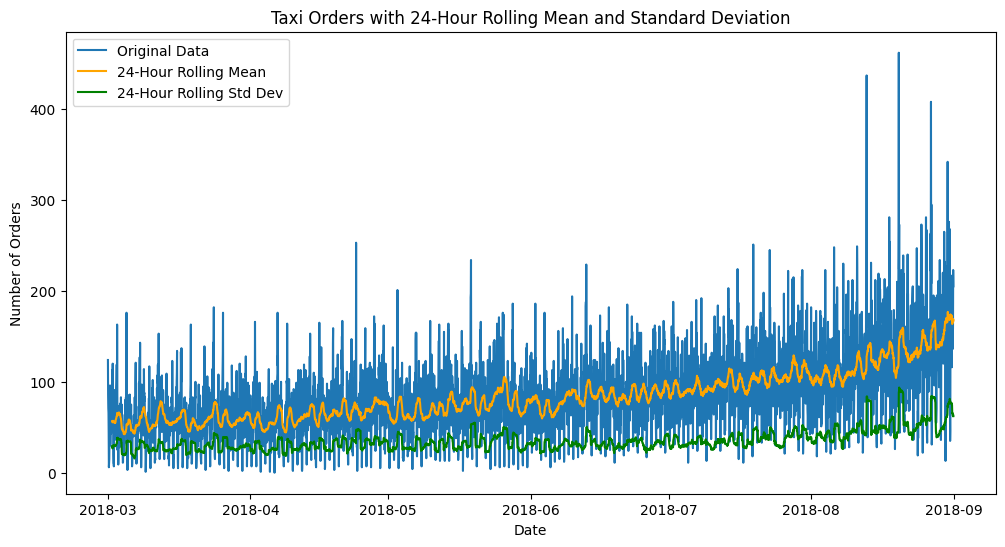

In [14]:
# 24-hour rolling mean and standard deviation
hourly_data['rolling_mean_24h'] = hourly_data['num_orders'].rolling(window=24).mean()
hourly_data['rolling_std_24h'] = hourly_data['num_orders'].rolling(window=24).std()

# plot rolling stats
plt.figure(figsize=(12, 6))
plt.plot(hourly_data['num_orders'], label="Original Data")
plt.plot(hourly_data['rolling_mean_24h'], label="24-Hour Rolling Mean", color='orange')
plt.plot(hourly_data['rolling_std_24h'], label="24-Hour Rolling Std Dev", color='green')
plt.title("Taxi Orders with 24-Hour Rolling Mean and Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.legend()
plt.show()

hourly_data['rolling_mean_24h'] calculates the 24-hour rolling mean, smoothing out short-term fluctuations to highlight daily trends, while hourly_data['rolling_std_24h'] captures the variability within each 24-hour period, indicating consistency in order volume. The orange rolling mean line shows the smoothed trend in order volume, helping identify patterns like peak hours or growth periods, while the green rolling standard deviation line reflects the spread in orders; rising fluctuations suggest increased variability, possibly due to changing demand.

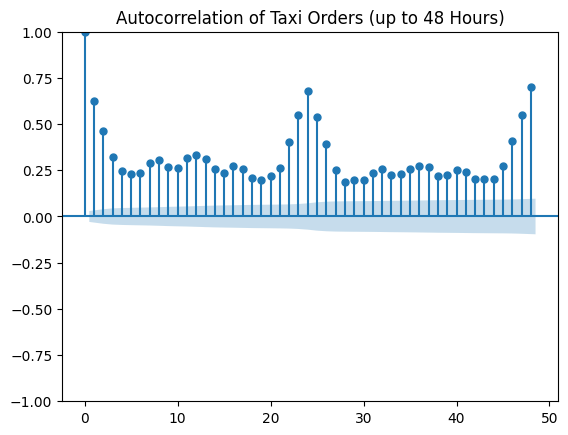

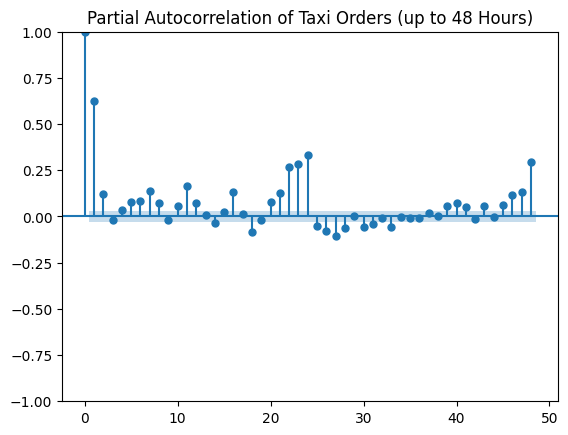

In [15]:
# autocorrelation plot
plot_acf(hourly_data['num_orders'], lags=48, title="Autocorrelation of Taxi Orders (up to 48 Hours)")
plt.show()

# partial autocorrelation plot
plot_pacf(hourly_data['num_orders'], lags=48, title="Partial Autocorrelation of Taxi Orders (up to 48 Hours)")
plt.show()

The autocorrelation plot reveals how current taxi orders relate to past values, showing seasonality patterns. The partial autocorrelation plot highlights which past values directly impact current orders, useful for selecting lags in predictive models. Together, these plots help identify seasonality and relevant time lags for forecasting.

## Training

In [16]:
# lag features
hourly_data['lag_1'] = hourly_data['num_orders'].shift(1)
hourly_data['lag_2'] = hourly_data['num_orders'].shift(2)
hourly_data['lag_3'] = hourly_data['num_orders'].shift(3)

In [17]:
# rolling stats
hourly_data['rolling_mean_3h'] = hourly_data['num_orders'].rolling(window=3).mean()
hourly_data['rolling_std_3h'] = hourly_data['num_orders'].rolling(window=3).std()
hourly_data['rolling_mean_6h'] = hourly_data['num_orders'].rolling(window=6).mean()
hourly_data['rolling_std_6h'] = hourly_data['num_orders'].rolling(window=6).std()

In [18]:
# time based features
hourly_data['hour'] = hourly_data.index.hour
hourly_data['day_of_week'] = hourly_data.index.dayofweek

hourly_data['is_weekend'] = hourly_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [19]:
# fill missing values created by lag and rolling features
hourly_data.fillna(0, inplace=True)

In [20]:
# final check - first 5 and last 5 rows displayed
display(hourly_data)

,num_orders,hour,day_of_week,rolling_mean_24h,rolling_std_24h,lag_1,lag_2,lag_3,rolling_mean_3h,rolling_std_3h,rolling_mean_6h,rolling_std_6h,is_weekend
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
2018-03-01 01:00:00,85,1,3,0.000000,0.000000,124.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
2018-03-01 02:00:00,71,2,3,0.000000,0.000000,85.0,124.0,0.0,93.333333,27.465129,0.000000,0.000000,0
2018-03-01 03:00:00,66,3,3,0.000000,0.000000,71.0,85.0,124.0,74.000000,9.848858,0.000000,0.000000,0
2018-03-01 04:00:00,43,4,3,0.000000,0.000000,66.0,71.0,85.0,60.000000,14.933185,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,167.541667,63.268908,207.0,217.0,197.0,186.666667,44.162578,167.666667,44.080230,0
2018-08-31 20:00:00,154,20,4,168.041667,63.105487,136.0,207.0,217.0,165.666667,36.909800,171.166667,41.537533,0
2018-08-31 21:00:00,159,21,4,166.416667,62.801908,154.0,136.0,207.0,149.666667,12.096832,178.333333,32.934278,0


In [21]:
# define target and features
target = 'num_orders'
features = hourly_data.drop(columns=[target])

# define target and feature sets
X = features
y = hourly_data[target]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [22]:
# initialize models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
lgbm_model = LGBMRegressor(random_state=42, n_estimators=100)

# define a function 
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

# train and evaluate models
linear_rmse = train_and_evaluate(linear_model, X_train, y_train, X_test, y_test)
rf_rmse = train_and_evaluate(rf_model, X_train, y_train, X_test, y_test)
lgbm_rmse = train_and_evaluate(lgbm_model, X_train, y_train, X_test, y_test)

print(f"Linear Regression RMSE: {linear_rmse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"LightGBM RMSE: {lgbm_rmse:.2f}")

Linear Regression RMSE: 1.30
Random Forest RMSE: 30.47
LightGBM RMSE: 30.42


In [23]:
# random forest hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best_model = rf_grid.best_estimator_
rf_best_rmse = -rf_grid.best_score_

# LightGBM hyperparameter tuning
lgbm_params = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.05]
}
lgbm_grid = GridSearchCV(lgbm_model, lgbm_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_grid.fit(X_train, y_train)
lgbm_best_model = lgbm_grid.best_estimator_
lgbm_best_rmse = -lgbm_grid.best_score_

print(f"Tuned Random Forest RMSE: {rf_best_rmse:.2f}")
print(f"Tuned LightGBM RMSE: {lgbm_best_rmse:.2f}")

Tuned Random Forest RMSE: 10.98
Tuned LightGBM RMSE: 9.26


In [24]:
# choose best model
final_model = lgbm_best_model 
final_predictions = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f"Final Model RMSE on Test Set: {final_rmse:.2f}")

Final Model RMSE on Test Set: 29.67


## Testing

In [25]:
# calculate RMSE on test set
final_predictions = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f"Final Model RMSE on Test Set: {final_rmse:.2f}")

Final Model RMSE on Test Set: 29.67


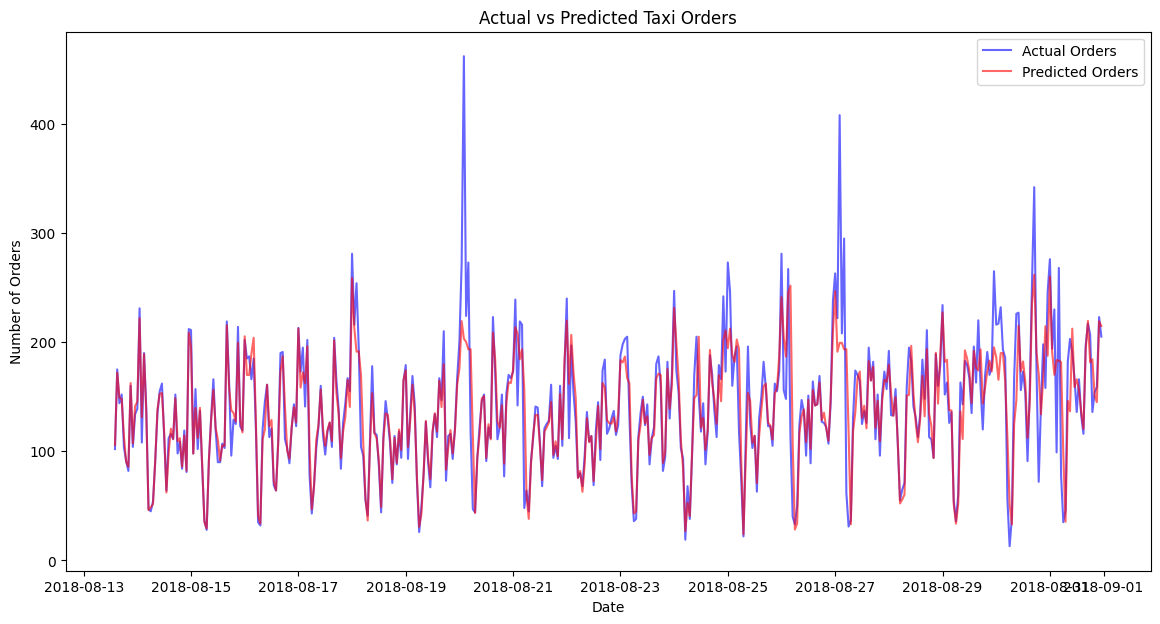

In [26]:
# analyze plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Orders', color='blue', alpha=0.6)
plt.plot(y_test.index, final_predictions, label='Predicted Orders', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.title('Actual vs Predicted Taxi Orders')
plt.legend()
plt.show()

The plot compares actual and predicted taxi orders, with the blue line showing the actual orders and the red line showing the model's predictions. It helps assess the model's accuracy by highlighting how closely the predictions align with the actual data.

# Conclusion

Our goal for the testing was to get RMSE under 48. The final model on the RMSE test set is 29.67 meaning it is acceptable. 

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48